# Baseline Performance

In this notebook I will obtain the baseline performances obtainable using simple machine learning on the "Cookie Theft Picture Test" section of the DementiaBank dataset. <br />
The numerical features are extracted using my feature extraction project [Link here](https://github.com/EdoStoppa/Dementia_Features_Extractor). Furthermore I will define some baseline performance dropping one feature category at a time.

### Imports
In this section all the import statements are divided in sub groups to help undestand what each of them does, and to aid an eventual partial run of the notebook (running only Regression, only Binary Classification, etc...)

In [1]:
# General import useful for each part of the notebook
import os
import numpy as np
import pandas as pd
import statistics
from matplotlib import pyplot as plt
from typing import Tuple, Callable, Any

In [2]:
# Import used to manipulate all the dataset for training/testing purpose
from sklearn.model_selection import KFold

In [3]:
# Regression Models
from sklearn.linear_model import Ridge
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor
# Regression Models Evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [4]:
# Classification Models (both Binary and Multi Class)
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, BaggingClassifier
# Classification Models Evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

In [5]:
# Needed to suppress some convergence warnings
from warnings import filterwarnings
filterwarnings('ignore')

### Preliminary Work
This section contains some fuction and variable definition that are useful in the Notebook.<br />
Please, check if all the paths are correct for you, and in case they're not, feel free to change them.

In [6]:
# Defining some useful variables

# Set the project folder
PRJ_FOLDER = '.'
# Set the folder the full dataset is located
DATA_FOLDER = os.path.join(PRJ_FOLDER, 'data')
# Set the name of the file that holds the full dataset
FULL_DATASET_NAME = 'feature_dataset.csv'
# Set the name of the file that holds the angraphic information
ANAGRAPHIC_DATASET_NAME = 'anagraphic_info.csv'
# Create a list with all the dataset names excluding the full dataset
SEP_DATASETS_FOLDER = os.path.join(DATA_FOLDER, 'separate_datasets')
# Set the folder where all the results will be saved
RES_FOLDER = os.path.join(PRJ_FOLDER, 'results')
# Flag needed to explicit if partial datasets should be built
BUILD_PARTIAL_DATASET = True

print(f'Folder where the entire project is located: {PRJ_FOLDER}')
print(f'Folder where the full dataset is saved: {DATA_FOLDER}')
print(f'Name of the full dataset: {FULL_DATASET_NAME}')
print(f'Name of the anagraphic dataset: {ANAGRAPHIC_DATASET_NAME}')
print(f'Separate features group datasets folder: {SEP_DATASETS_FOLDER}')
print(f'Folder where all results will be saved: {RES_FOLDER}')
print(f'Flag for building partial datasets set to {BUILD_PARTIAL_DATASET}')

Folder where the entire project is located: .
Folder where the full dataset is saved: .\data
Name of the full dataset: feature_dataset.csv
Name of the anagraphic dataset: anagraphic_info.csv
Separate features group datasets folder: .\data\separate_datasets
Folder where all results will be saved: .\results
Flag for building partial datasets set to True


In [7]:
# Retrieve the names of all elements in the project folder PRJ_FOLDER
elements = os.listdir(PRJ_FOLDER)

# Fix (if necessary) the folder structure of RES_FOLDER
if 'results' not in elements:
    os.makedirs(os.path.join(RES_FOLDER, 'regression'))
    os.makedirs(os.path.join(RES_FOLDER, 'binary_classification'))
    os.makedirs(os.path.join(RES_FOLDER, 'multi_classification'))
else:
    if 'regression' not in os.listdir(RES_FOLDER):
        os.makedirs(os.path.join(RES_FOLDER, 'regression'))
    if 'binary_classification' not in os.listdir(RES_FOLDER):
        os.makedirs(os.path.join(RES_FOLDER, 'binary_classification'))
    if 'multi_classification' not in os.listdir(RES_FOLDER):
        os.makedirs(os.path.join(RES_FOLDER, 'multi_classification'))

### Datasets Loading
In this section there are two functions used to load all the required data, and another function that is used to craft all the partial datasets.

In [8]:
# If the flag is TRUE, create all the partial datasets and save them in DATA_FOLDER

if BUILD_PARTIAL_DATASET:
    # Load the full dataset into pandas
    full_dataset = pd.read_csv(os.path.join(DATA_FOLDER, FULL_DATASET_NAME))

    for to_remove in os.listdir(SEP_DATASETS_FOLDER):
        # Avoid removing the anagraphic information
        if to_remove != ANAGRAPHIC_DATASET_NAME:
            # Get all the names of the features that should be removed
            to_remove_dataframe = pd.read_csv(os.path.join(SEP_DATASETS_FOLDER, to_remove))
            to_remove_columns = to_remove_dataframe.columns.to_list()[1:]

            # Create a partial dataset dataframe
            new_dataset = full_dataset.drop(to_remove_columns, axis=1)

            # Save the dataset
            with open(os.path.join(DATA_FOLDER, f'{to_remove.split(".")[0]}_removed.csv'), 'w+') as out:
                new_dataset.to_csv(out, index=False)

In [9]:
# Let's define a simple function that loads a single dataset

def load_raw_data(csv_path: str, feat_to_predict: str) -> Tuple[np.ndarray, np.ndarray, list]:
    # Load the entire csv file
    data = pd.read_csv(csv_path)

    # Get only the labels
    labels = pd.DataFrame(data[feat_to_predict], columns=[feat_to_predict])

    # Remove the unnecessary columns
    data = data.drop(['id', 'mmse', 'bin_class', 'multi_class'], axis=1)

    return data.to_numpy(), labels.to_numpy().reshape((len(labels), )), data.columns.to_list()

In [10]:
# This function loads all datasets, and make them ready for training/testing

def load_processed_data(sep_data_folder: str, data_folder: str, feat_to_predict: str, num_folds: int):
    DATASETS = []
    FOLDS = []
    COLUMNS = []

    # Get the name of the folder containing the partial datasets
    name_sep_folder = sep_data_folder.split(os.path.sep)[-1]
    # Get the name of all datasets present
    DATASETS_NAMES = [dataset for dataset in os.listdir(data_folder) if dataset != name_sep_folder]

    # Load every dataset 
    for name in DATASETS_NAMES:
        print(f'Loading {name}')
        # Get the raw data
        data, labels, cols = load_raw_data(os.path.join(data_folder, name), feat_to_predict)
        # Create the iterator responsible of dividing the dataset to do KFold cross validation
        kfold = KFold(n_splits=num_folds)
        # Divide the data in training and test set
        folds = []
        for train_index, test_index in kfold.split(data):
            folds.append((train_index, test_index))
        
        DATASETS.append((data, labels))
        FOLDS.append(folds)
        COLUMNS.append(cols)
    
    print('\nAll data loaded!')
    return DATASETS_NAMES, DATASETS, COLUMNS, FOLDS

## Training Functions

In [11]:
# Function used to train both the regression and classification models

def train_models(models_generator: Callable[[], Any], datasets: list, datasets_names: list, kfolds: list) -> list:
    ready_models = []
    for data, data_name, folds in zip(datasets, datasets_names, kfolds):
        print(f'Working on {data_name}')

        # Unwrap data
        dataset, label = data
        
        # Train a model for each fold
        trained_folds = []
        for fold in folds:
            train_index, _ = fold
            X_train, y_train = dataset[train_index], label[train_index]

            # Generate new batch of models
            models = models_generator()
            
            fold_models = []
            for model, model_name in models:
                # Train model
                model.fit(X_train, y_train)
                # Save model
                fold_models.append((model_name, model))

            # Save all trained models for the fold
            trained_folds.append(fold_models)

        # Save all the trained fold models for the daaset
        ready_models.append(trained_folds)
        print('\n**********************************************\n')

    return ready_models

## Evaluation Functions

In [12]:
def plot_results(cols: list, data: dict, y_name: str, title: str, dimensions: tuple, precision=1.0):
    # Extract the max value on the Y axis
    max_y = np.ceil(max([max(item) for _, item in data.items()]))
    # Format the data in order to be fed to Pandas
    data = [[key] + item for key, item in data.items()]
    # Create a Dataframe
    df = pd.DataFrame(data, columns=['Model']+cols)
    # Create the base plot using Pandas
    df.plot(x="Model", y=cols, kind="bar", figsize=dimensions)
    
    # Fix the last few things in the plot, then show it
    plt.title(title)
    plt.ylabel(y_name)
    plt.xticks(rotation = 30)
    plt.yticks(np.arange(0, max_y, precision))
    plt.show()
    

In [13]:
# Function used to evaluate the regression models

def evaluate_regression_models(ready_models: list, datasets: list, datasets_names: list, kfolds: list) -> list:
    evaluation_results = []
    avg_to_plot = {name[0]: [] for name in ready_models[0][0]}
    std_to_plot = {name[0]: [] for name in ready_models[0][0]}
    
    for kmodels_matrix, folds, data, name in zip(ready_models, kfolds, datasets, datasets_names):
        # Preprocess the name removing the file extension
        name = name.split('.')[0]
        # Unwrap data
        dataset, label = data
        
        # Reorganize the models
        kmodels_matrix = list(map(list, zip(*kmodels_matrix)))
        out = ''
        for models_list in kmodels_matrix:
                       
            mae, rmse, r2 = [], [], []
            for (model_name, model), fold in zip(models_list, folds):
                _, test_index = fold
                X_test, y_test = dataset[test_index], label[test_index]
                # Compute the predictions for the test dataset
                predictions = model.predict(X_test)

                mae.append(mean_absolute_error(y_test, predictions))
                rmse.append(np.sqrt(mean_squared_error(y_test, predictions)))
                r2.append(r2_score(y_test, predictions))
            
            # Compute the average and standard deviation of each metric
            mae_avg, mae_std = statistics.mean(mae), statistics.stdev(mae)
            rmse_avg, rmse_std = statistics.mean(rmse), statistics.stdev(rmse)
            r2_avg, r2_std = statistics.mean(r2), statistics.stdev(r2)

            # Save data in dictionary ready to be plotted
            avg_to_plot[model_name].append(rmse_avg)
            std_to_plot[model_name].append(rmse_std)

            # Compute all the interesting metrics
            out += f'{model_name}\n\n'
            out += f'MAE                \tAvg: {mae_avg:.3f}\tStdDev: {mae_std:.3f}\n'
            out += f'RMSE               \tAvg: {rmse_avg:.3f}\tStdDev: {rmse_std:.3f}\n'
            out += f'R2                 \tAvg: {r2_avg:.3f}\tStdDev: {r2_std:.3f}\n'
            out += '\n****************************************************************\n\n'

        evaluation_results.append((name, out))

    plot_results(datasets_names, avg_to_plot, 'RMSE', 'Regression Performance (Avg)', (15,9), precision=0.5)
    plot_results(datasets_names, std_to_plot, 'RMSE', 'Regression Performance (Std Dev)', (15,9), precision=0.2)
    
    return evaluation_results

In [14]:
# Function used to evaluate the binary classification models

def evaluate_classification_models(ready_models: list, datasets: list, datasets_names: list, kfolds: list, typ: str) -> list:
    evaluation_results = []
    avg_to_plot = {name[0]: [] for name in ready_models[0][0]}
    std_to_plot = {name[0]: [] for name in ready_models[0][0]}
    
    for kmodels_matrix, folds, data, name in zip(ready_models, kfolds, datasets, datasets_names):
        # Preprocess the name removing the file extension
        name = name.split('.')[0]
        # Unwrap data
        dataset, label = data
        
        # Reorganize the models
        kmodels_matrix = list(map(list, zip(*kmodels_matrix)))
        out = ''
        for models_list in kmodels_matrix:
                       
            acc, prec, rec, f1 = [], [], [], []
            for (model_name, model), fold in zip(models_list, folds):
                _, test_index = fold
                X_test, y_test = dataset[test_index], label[test_index]
                # Compute the predictions for the test dataset
                predictions = model.predict(X_test)

                acc.append(accuracy_score(y_test, predictions))
                prec.append(precision_score(y_test, predictions, average='micro'))
                rec.append(recall_score(y_test, predictions, average='micro'))
                f1.append(f1_score(y_test, predictions, average='micro'))
            
            # Compute the average and standard deviation of each metric
            acc_avg, acc_std = statistics.mean(acc), statistics.stdev(acc)
            prec_avg, prec_std = statistics.mean(prec), statistics.stdev(prec)
            rec_avg, rec_std = statistics.mean(rec), statistics.stdev(rec)
            f1_avg, f1_std = statistics.mean(f1), statistics.stdev(f1)

            # Save data in dictionary ready to be plotted
            avg_to_plot[model_name].append(acc_avg)
            std_to_plot[model_name].append(acc_std)

            # Compute all the interesting metrics
            
            out += f'{model_name}\n\n'
            out += f'Accuracy:          \tAvg: {acc_avg:.3f}\tStdDev: {acc_std:.3f}\n'
            out += f'Precision:         \tAvg: {prec_avg:.3f}\tStdDev: {prec_std:.3f}\n'
            out += f'Recall:            \tAvg: {rec_avg:.3f}\tStdDev: {rec_std:.3f}\n'
            out += f'F1:                \tAvg: {f1_avg:.3f}\tStdDev: {f1_std:.3f}\n'
            out += '\n**********************************************\n\n'

        evaluation_results.append((name, out))

    plot_results(datasets_names, avg_to_plot, 'Accuracy', f'{typ} Classification Performance (Avg)', (15,9), precision=0.1)
    plot_results(datasets_names, std_to_plot, 'Accuracy', f'{typ} Classification Performance (Std Dev)', (15,9), precision=0.1)
    
    return evaluation_results
    

In [15]:
# Function used to save the results in the correct files

def save_results(results: list, save_folder: str, task: str):
    for name, out in results:
        with open(os.path.join(save_folder, task, name), 'w+') as file:
            file.write(out)


## Regression
In this section we are going to evalute the performance of different regression models.<br />
In particular, we're going to predict the MMSE score of each conversation using these models:
- Linear Regression
- Ridge Regression
- Boosted Trees
- Bagged Trees
- Decision Tree
- Support Vector Machine Regressor

In [16]:
# Let's set some important variables first

FEATURE_TO_PREDICT = 'mmse'
NUM_FOLDS = 5

In [17]:
# Loading the datasets and preparing them for training & testing
DATASETS_NAMES, DATASETS, COLUMNS, FOLDS = load_processed_data(SEP_DATASETS_FOLDER, DATA_FOLDER, FEATURE_TO_PREDICT, NUM_FOLDS)


Loading acoustic_info_removed.csv
Loading discourse_info_removed.csv
Loading feature_dataset.csv
Loading lexicosyntactic_info_removed.csv
Loading psycholinguistic_info_removed.csv
Loading spatial_info_removed.csv

All data loaded!


In [18]:
# A simple function that generates a fresh batch of regression models ready to be trained

def get_regression_models() -> list:
    models = [(Ridge(), 'Ridge Regression'), (KNeighborsRegressor(), 'KNN Regressor'),
              (GradientBoostingRegressor(), 'Boosted Trees'), (BaggingRegressor(), 'Bagged Trees'), 
              (DecisionTreeRegressor(), 'Decision Tree'), (LinearSVR(max_iter=10000), 'SVM')]

    return models

In [19]:
# Train all these regression models
trained_regression_models = train_models(get_regression_models, DATASETS, DATASETS_NAMES, FOLDS)

Working on acoustic_info_removed.csv

**********************************************

Working on discourse_info_removed.csv

**********************************************

Working on feature_dataset.csv

**********************************************

Working on lexicosyntactic_info_removed.csv

**********************************************

Working on psycholinguistic_info_removed.csv

**********************************************

Working on spatial_info_removed.csv

**********************************************



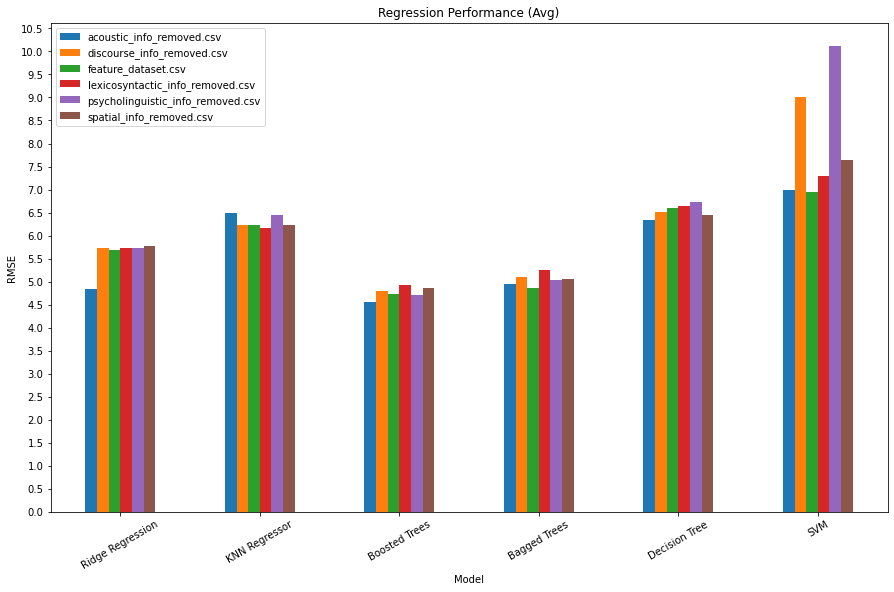

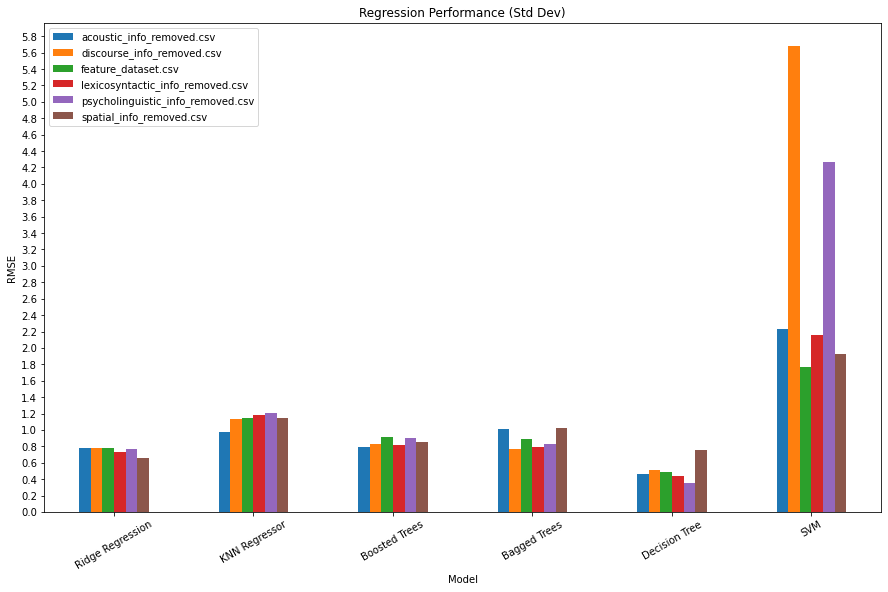

In [20]:
# Evaluate all the models
regression_results = evaluate_regression_models(trained_regression_models, DATASETS, DATASETS_NAMES, FOLDS)

# Save the results to different files
save_results(regression_results, RES_FOLDER, 'regression')

## Binary Classification
In this section we are going to evaluate multiple classification models.<br />
In particular, we are going to predict if each conversation was made by a patient with Dementia or by a control patient. We will use these models:
- Decision Tree
- Linear Discriminant Classifier
- Logistic Regression
- Gaussian Naive Bayes
- Linear Support Vector Classifier
- K-Nearest Neighbors Classifier
- Boosted Trees
- Bagged Trees

In [21]:
# Let's set some important variables first

FEATURE_TO_PREDICT = 'bin_class'
NUM_FOLDS = 5

In [22]:
# Loading the datasets and preparing them for training & testing
DATASETS_NAMES, DATASETS, COLUMNS, FOLDS = load_processed_data(SEP_DATASETS_FOLDER, DATA_FOLDER, FEATURE_TO_PREDICT, NUM_FOLDS)

Loading acoustic_info_removed.csv
Loading discourse_info_removed.csv
Loading feature_dataset.csv
Loading lexicosyntactic_info_removed.csv
Loading psycholinguistic_info_removed.csv
Loading spatial_info_removed.csv

All data loaded!


In [23]:
# A simple function that generates a fresh batch of binary classification models ready to be trained

def get_binary_class_models() -> list:
    models = [(DecisionTreeClassifier(), 'Decision Trees'), (LinearDiscriminantAnalysis(), 'Linear Discriminant Classifier'),
              (LogisticRegression(), 'Logistic Regression'), (GaussianNB(), 'Gaussian Naive Bayes'),
              (LinearSVC(max_iter=10000), 'Linear Support Vector Classifier'), (KNeighborsClassifier(), 'KNN Classifier'),
              (GradientBoostingClassifier(), 'Boosted Trees'), (BaggingClassifier(), 'Bagged Trees')]
    return models

In [24]:
# Train all the models
trained_binary_class_models = train_models(get_binary_class_models, DATASETS, DATASETS_NAMES, FOLDS)

Working on acoustic_info_removed.csv

**********************************************

Working on discourse_info_removed.csv

**********************************************

Working on feature_dataset.csv

**********************************************

Working on lexicosyntactic_info_removed.csv

**********************************************

Working on psycholinguistic_info_removed.csv

**********************************************

Working on spatial_info_removed.csv

**********************************************



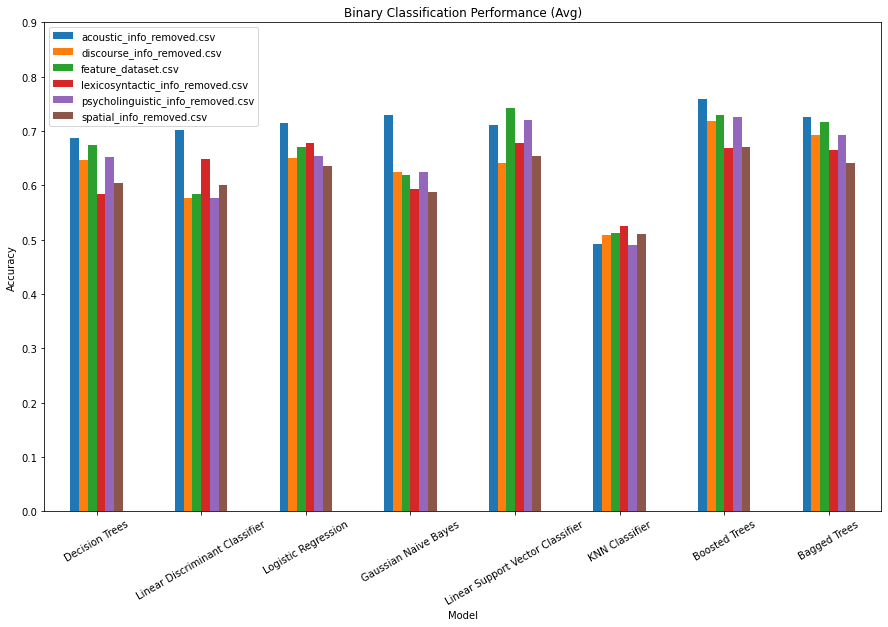

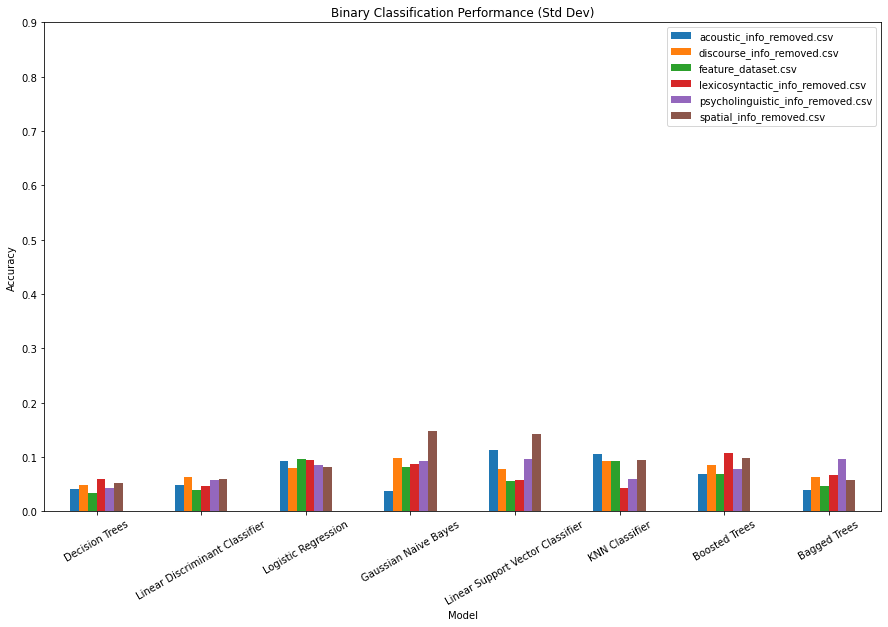

In [25]:
# Evaluate all the models
bin_class_results = evaluate_classification_models(trained_binary_class_models, DATASETS, DATASETS_NAMES, FOLDS, 'Binary')

# Save the results to different files
save_results(bin_class_results, RES_FOLDER, 'binary_classification')

## Multi class Classification
In this section we introduce a new task: Multi Class classification. The conversation are labeled with a number (0 to 4) that represents the Dementia Level of the Patient that made the conversation. The models used are the exact same as the Binary Classification task.

In [26]:
# Let's set some important variables first

FEATURE_TO_PREDICT = 'multi_class'
NUM_FOLDS = 5

In [27]:
# Loading the datasets and preparing them for training & testing
DATASETS_NAMES, DATASETS, COLUMNS, FOLDS = load_processed_data(SEP_DATASETS_FOLDER, DATA_FOLDER, FEATURE_TO_PREDICT, NUM_FOLDS)

Loading acoustic_info_removed.csv
Loading discourse_info_removed.csv
Loading feature_dataset.csv
Loading lexicosyntactic_info_removed.csv
Loading psycholinguistic_info_removed.csv
Loading spatial_info_removed.csv

All data loaded!


In [28]:
# A simple function that generates a fresh batch of binary classification models ready to be trained

def get_multi_class_models() -> list:
    models = [(DecisionTreeClassifier(), 'Decision Trees'), (LinearDiscriminantAnalysis(), 'Linear Discriminant Classifier'),
              (LogisticRegression(), 'Logistic Regression'), (GaussianNB(), 'Gaussian Naive Bayes'),
              (LinearSVC(max_iter=10000), 'Linear Support Vector Classifier'), (KNeighborsClassifier(), 'KNN Classifier'),
              (GradientBoostingClassifier(), 'Boosted Trees'), (BaggingClassifier(), 'Bagged Trees')]
    return models

In [29]:
# Train all the models
trained_binary_class_models = train_models(get_multi_class_models, DATASETS, DATASETS_NAMES, FOLDS)

Working on acoustic_info_removed.csv

**********************************************

Working on discourse_info_removed.csv

**********************************************

Working on feature_dataset.csv

**********************************************

Working on lexicosyntactic_info_removed.csv

**********************************************

Working on psycholinguistic_info_removed.csv

**********************************************

Working on spatial_info_removed.csv

**********************************************



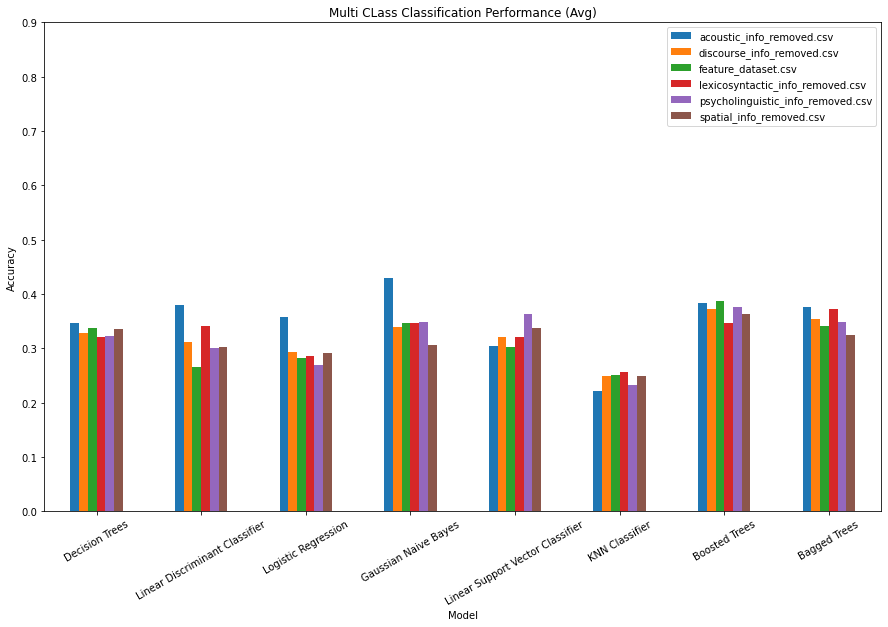

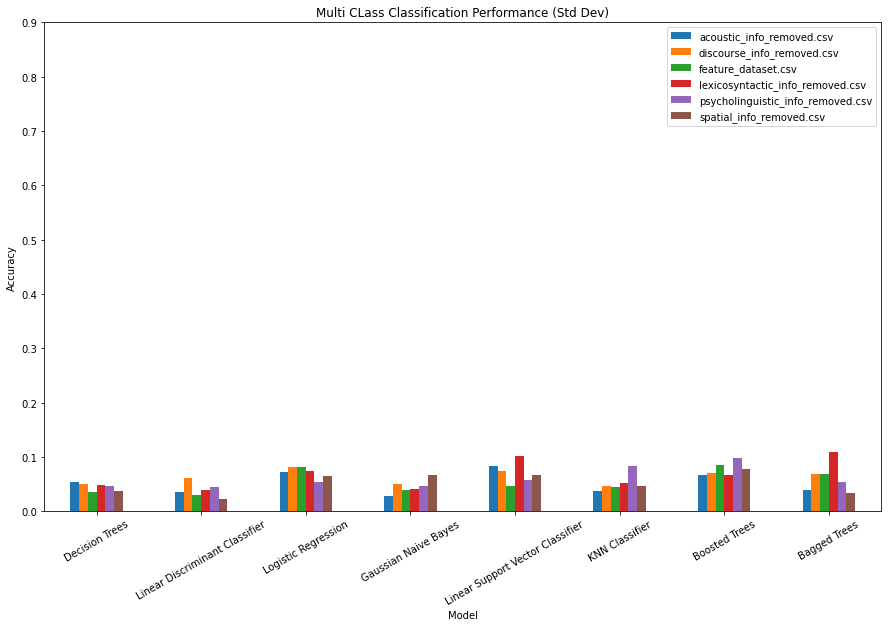

In [30]:
# Evaluate all the models
multi_class_results = evaluate_classification_models(trained_binary_class_models, DATASETS, DATASETS_NAMES, FOLDS, 'Multi CLass')

# Save the results to different files
save_results(multi_class_results, RES_FOLDER, 'multi_classification')